## Problem Overview:

### Who is currently the best player in this league?

In order to answer this given the data we have on hand, my thought is to create a crude expected goals model and consider the best player the one who creates the most goals/expected goals. "Creates" in this context means they actually scored themselves or had a preshot pass that led to a goal. Given the data, it will be difficult to value goalies since the best way to evaluate them would be to see how many expected goals they stopped. I'm not going to consider my expected goals model to be incredibly accurate given the data on hand, so I will limit my evaluation to skaters. We will start by importing all necessary libraries and then move into our analysis.

## Import Libraries

In [45]:
# standard libraries
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 40)
pd.options.mode.chained_assignment = None

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

## Load and Inspect Data

In [2]:
df = pd.read_csv("./data_project_dataset.csv")

In [5]:
df.head()

,Unnamed: 0,season,game_id,period,period_time,event,team,opp,team_score,opp_score,team_skaters,opp_skaters,team_p1,team_p2,team_p3,team_p4,team_p5,team_p6,team_goalie,opp_p1,opp_p2,opp_p3,opp_p4,opp_p5,opp_p6,opp_goalie,is_goal,shot_x,shot_y,is_shot_a_rebound,is_shot_off_the_rush,is_pre_shot_pass,pre_shot_pass_x,pre_shot_pass_y,shot_type,shooter_id,passer_id
0,1,1,2,1,0.000,Faceoff,19,14,0,0,5,5,74,926,1175,1801.0,2037.0,NaN,1101.0,304,769,1346,1773.0,1997.0,NaN,1378.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2,1,2,1,22.786,Faceoff,14,19,0,0,5,5,304,769,1346,1773.0,1997.0,NaN,1378.0,74,926,1175,1801.0,2037.0,NaN,1101.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
2,3,1,2,1,41.536,Faceoff,14,19,0,0,5,5,840,1086,1356,1580.0,1904.0,NaN,1378.0,631,1175,1948,1956.0,2015.0,NaN,1101.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
3,4,1,2,1,93.772,Shot,14,19,0,0,5,5,840,1086,1356,1580.0,1904.0,NaN,1378.0,631,1175,1948,1956.0,2015.0,NaN,1101.0,0.0,34.51,-7.593795,0.0,0.0,0,NaN,NaN,wristshot,840.0,NaN
4,5,1,2,1,94.563,Faceoff,14,19,0,0,5,5,821,841,1025,1657.0,1766.0,NaN,1378.0,167,226,638,1016.0,1780.0,NaN,1101.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN


In [83]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,580397.0,290199.000000,167546.326431,1.000000,145100.000000,290199.000000,435298.000000,580397.000000
season,580397.0,1.461481,0.498514,1.000000,1.000000,1.000000,2.000000,2.000000
game_id,580397.0,706.683832,408.680385,1.000000,352.000000,707.000000,1062.000000,1412.000000
period,580397.0,2.006166,0.825032,1.000000,1.000000,2.000000,3.000000,4.000000
period_time,580397.0,607.020155,342.103310,0.000000,311.013000,606.546000,902.285000,1200.000000
team,580397.0,12.147820,7.109373,1.000000,6.000000,12.000000,18.000000,24.000000
opp,580397.0,12.378451,7.027992,1.000000,7.000000,12.000000,19.000000,24.000000
team_score,580397.0,1.168135,1.289419,0.000000,0.000000,1.000000,2.000000,9.000000
opp_score,580397.0,1.225721,1.324332,0.000000,0.000000,1.000000,2.000000,9.000000
team_skaters,580397.0,4.972445,0.233374,3.000000,5.000000,5.000000,5.000000,6.000000


In [6]:
df["event"].unique()

array(['Faceoff', 'Shot', 'Shift Change'], dtype=object)

## Limit Events of Interest to Shots

The best method to evaluate players in the context of the data on hand is to limit the event to shots since it will be difficult to value a faceoff. We will first subset the existing data and then convert the shot x position to be relative to the opponent goal (this will help with the expected goals model).

In [9]:
df_shots = df.loc[df["event"] == "Shot"]

In [12]:
# Convert the shot_x position to be relative to the opponent's goal
DIST_TO_GOAL = 89 # Rink is 200 ft long so the distance to the goal is 100 - 11 ft
df_shots["shot_x"] = DIST_TO_GOAL - df_shots["shot_x"]

# Calculate the Euclidean distance from the goal of the shot - this will be a big factor in xGoals
df_shots["shot_distance"] = np.sqrt(df_shots["shot_x"]**2 + df_shots["shot_y"]**2)

In [13]:
df_shots.head()

,Unnamed: 0,season,game_id,period,period_time,event,team,opp,team_score,opp_score,team_skaters,opp_skaters,team_p1,team_p2,team_p3,team_p4,team_p5,team_p6,team_goalie,opp_p1,opp_p2,opp_p3,opp_p4,opp_p5,opp_p6,opp_goalie,is_goal,shot_x,shot_y,is_shot_a_rebound,is_shot_off_the_rush,is_pre_shot_pass,pre_shot_pass_x,pre_shot_pass_y,shot_type,shooter_id,passer_id,shot_distance
3,4,1,2,1,93.772,Shot,14,19,0,0,5,5,840,1086,1356,1580.0,1904.0,NaN,1378.0,631,1175,1948,1956.0,2015.0,NaN,1101.0,0.0,34.51,-7.593795,0.0,0.0,0,NaN,NaN,wristshot,840.0,NaN,35.335617
5,6,1,2,1,96.148,Shot,14,19,0,0,5,5,821,841,1025,1657.0,1766.0,NaN,1378.0,167,226,638,1016.0,1780.0,NaN,1101.0,0.0,50.46,-16.253795,0.0,0.0,1,62.83,-14.453795,wristshot,1766.0,1657.0,53.013182
7,8,1,2,1,97.784,Shot,14,19,0,0,5,5,821,841,1025,1657.0,1766.0,NaN,1378.0,167,226,638,1016.0,1780.0,NaN,1101.0,0.0,55.58,-28.523795,0.0,0.0,1,58.60,-17.703795,wristshot,1766.0,1657.0,62.471940
12,13,1,2,1,160.796,Shot,19,14,0,0,5,5,926,937,1523,1935.0,2037.0,NaN,1101.0,769,1011,1170,1346.0,1356.0,NaN,1378.0,0.0,8.96,3.556205,0.0,0.0,0,NaN,NaN,slapshot,937.0,NaN,9.639927
16,17,1,2,1,193.732,Shot,19,14,0,0,5,5,74,631,926,1523.0,2037.0,NaN,1101.0,769,1346,1356,1773.0,1997.0,NaN,1378.0,0.0,77.26,-16.983795,0.0,0.0,1,55.58,-46.543795,wristshot,2037.0,926.0,79.104721


## Expected Goals Calculation

This next chunk of code will create an expected goals data frame "df_xg" that will only include the columns of data that are valuable in determining whether or not the result of the shot was a goal. These factors are listed as follows:
- Is Goal: our target variable - whether or not the shot resulted in a goal
- Is Shot a Rebound
- Is Shot Off the Rush
- Shot Type
- Shot Distance

In [50]:
df_xg = df_shots.loc[:,["is_goal","is_shot_a_rebound","is_shot_off_the_rush", "shot_type","shot_distance"]]

In [15]:
df_xg.head()

,is_goal,is_shot_a_rebound,is_shot_off_the_rush,shot_type,shot_distance
3,0.0,0.0,0.0,wristshot,35.335617
5,0.0,0.0,0.0,wristshot,53.013182
7,0.0,0.0,0.0,wristshot,62.471940
12,0.0,0.0,0.0,slapshot,9.639927
16,0.0,0.0,0.0,wristshot,79.104721


Machine learning models tend to have a difficult time with string categorical values so I will use the pd.get_dummies() function to convert the shot type into a boolean matrix that can be handled.

In [51]:
df_xg = pd.get_dummies(df_xg, columns = ["shot_type"])

As you can see from the histogram below, there is a significant amount of class imbalance, i.e. there are many more shots than goals. If using a different type of machine learning model, it would be prudent to account for this class imbalance by either upsampling goals or downsampling shots. The good thing about using a Random Forest is it can account for this class imbalance through the ensemble of decision trees meaning I will not be up- or downsampling.

<AxesSubplot: >

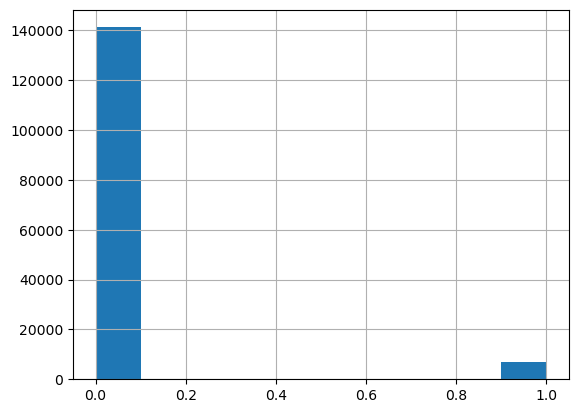

In [32]:
df_xg["is_goal"].hist()

Next, we will define our features and target as X and y, respectively, where X are the features of interest in created the expected goals calculation and y is whether or not the shot resulted in a goal.

In [53]:
X = df_xg.drop("is_goal", axis = 1)
y = df_xg["is_goal"]

We must be able to test our expected goals model on a subset of the data to ensure the model doesn't overfit to the training data. It is uneccessary for a random forest, but I will also standardize the features to attempt to help model performance.

In [54]:
indices = df_xg.index.values

X_train, X_test, index_train, index_test = train_test_split(X, indices, test_size = 0.2)
y_train, y_test = y[index_train], y[index_test]

sc_X = StandardScaler()
sc_X.fit(X_train)
X_train_std = sc_X.transform(X_train)
X_test_std  = sc_X.transform(X_test)

Now I will train a random forest classifier on the the training data defined above and test the accuracy of the model on the test data.

In [56]:
rf = RandomForestClassifier().fit(X_train, y_train)

y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9182290261667116


An accuracy of 92% seems fairly good given the class imbalance, I will proceed with this model and output the prediction probabilities of each class (no goal, goal) and use the probability of a goal as the "expected goals" from a given shot. 

In [57]:
train_prob = rf.predict_proba(X_train)
test_prob  = rf.predict_proba(X_test)

Add the xGoals information back to the shots dataset for grouping and filtering.

In [61]:
df_shots.loc[index_train, "xGoal"] = train_prob[:,1]
df_shots.loc[index_test, "xGoal"]  = test_prob[:,1]

In [62]:
df_shots.head()

,Unnamed: 0,season,game_id,period,period_time,event,team,opp,team_score,opp_score,team_skaters,opp_skaters,team_p1,team_p2,team_p3,team_p4,team_p5,team_p6,team_goalie,opp_p1,opp_p2,opp_p3,opp_p4,opp_p5,opp_p6,opp_goalie,is_goal,shot_x,shot_y,is_shot_a_rebound,is_shot_off_the_rush,is_pre_shot_pass,pre_shot_pass_x,pre_shot_pass_y,shot_type,shooter_id,passer_id,shot_distance,xGoal
3,4,1,2,1,93.772,Shot,14,19,0,0,5,5,840,1086,1356,1580.0,1904.0,NaN,1378.0,631,1175,1948,1956.0,2015.0,NaN,1101.0,0.0,34.51,-7.593795,0.0,0.0,0,NaN,NaN,wristshot,840.0,NaN,35.335617,0.0
5,6,1,2,1,96.148,Shot,14,19,0,0,5,5,821,841,1025,1657.0,1766.0,NaN,1378.0,167,226,638,1016.0,1780.0,NaN,1101.0,0.0,50.46,-16.253795,0.0,0.0,1,62.83,-14.453795,wristshot,1766.0,1657.0,53.013182,0.0
7,8,1,2,1,97.784,Shot,14,19,0,0,5,5,821,841,1025,1657.0,1766.0,NaN,1378.0,167,226,638,1016.0,1780.0,NaN,1101.0,0.0,55.58,-28.523795,0.0,0.0,1,58.60,-17.703795,wristshot,1766.0,1657.0,62.471940,0.0
12,13,1,2,1,160.796,Shot,19,14,0,0,5,5,926,937,1523,1935.0,2037.0,NaN,1101.0,769,1011,1170,1346.0,1356.0,NaN,1378.0,0.0,8.96,3.556205,0.0,0.0,0,NaN,NaN,slapshot,937.0,NaN,9.639927,0.0
16,17,1,2,1,193.732,Shot,19,14,0,0,5,5,74,631,926,1523.0,2037.0,NaN,1101.0,769,1346,1356,1773.0,1997.0,NaN,1378.0,0.0,77.26,-16.983795,0.0,0.0,1,55.58,-46.543795,wristshot,2037.0,926.0,79.104721,0.1


## Calculate the Goals and Direct Assists Accounted for by Each Player

This next step will be to calculate the goals and direct assists accounted for by each player. Direct assists are considered those that have the "is_pre_shot_pass" indicator set equal to 1. The best player will have accounted for the most goals and expected goals over the course of the previous two seasons.

In [76]:
goals   = df_shots.filter(["is_goal","xGoal","shooter_id"]).groupby("shooter_id").sum()
assists = df_shots.query("is_goal == 1 & is_pre_shot_pass == 1").filter(["is_goal","xGoal","passer_id"]).groupby("passer_id").sum()

In [81]:
(goals + assists).sort_values(by = "xGoal", ascending = False).dropna()

,is_goal,xGoal
300.0,83.0,59.070000
1993.0,64.0,55.717500
12.0,55.0,50.466500
1756.0,71.0,48.910000
1805.0,62.0,48.575167
...,...,...
149.0,1.0,0.640000
258.0,1.0,0.550000
880.0,1.0,0.500000
14.0,1.0,0.200000


## Goals / xGoals Summary

From a pure goals perspective, player 300 accounted for 83 goals and ~59 expected goals meaning he is the best player from a pure goal generation perspective. I will continue my analysis below by supplementally creating a Corsi value for each player and seeing how it stacks up to the goals/xGoals calculation.

## Corsi for each Player

Another metric that can be used to evaluate how effective a player is is how many shots they account for while on ice vs how many shots they give up while on the ice. I will use this as a supplemental metric to the above and see if I can gather any positive or negative information about a player given this additional information.

In [119]:
total_shots_for_1 = df_shots.filter(["event", "team_p1"]).groupby("team_p1").count()
total_shots_for_2 = df_shots.filter(["event", "team_p2"]).groupby("team_p2").count()
total_shots_for_3 = df_shots.filter(["event", "team_p3"]).groupby("team_p3").count()
total_shots_for_4 = df_shots.filter(["event", "team_p4"]).groupby("team_p4").count()
total_shots_for_5 = df_shots.filter(["event", "team_p5"]).groupby("team_p5").count() 

total_shots_against_1 = df_shots.filter(["event", "opp_p1"]).groupby("opp_p1").count()
total_shots_against_2 = df_shots.filter(["event", "opp_p2"]).groupby("opp_p2").count()
total_shots_against_3 = df_shots.filter(["event", "opp_p3"]).groupby("opp_p3").count()
total_shots_against_4 = df_shots.filter(["event", "opp_p4"]).groupby("opp_p4").count()
total_shots_against_5 = df_shots.filter(["event", "opp_p5"]).groupby("opp_p5").count() 

In [122]:
total_shots_for = pd.concat([total_shots_for_1, 
                             total_shots_for_2, 
                             total_shots_for_3, 
                             total_shots_for_4, 
                             total_shots_for_5], axis=1).fillna(0).sum(axis=1)

total_shots_against = pd.concat([total_shots_against_1, 
                                 total_shots_against_2, 
                                 total_shots_against_3, 
                                 total_shots_against_4, 
                                 total_shots_against_5], axis=1).fillna(0).sum(axis=1)

In [123]:
corsi = total_shots_for - total_shots_against

In [125]:
corsi.sort_values(ascending = False).dropna()

300.0     1458.0
148.0     1151.0
1993.0    1094.0
1805.0    1075.0
59.0       961.0
           ...  
1444.0    -614.0
1387.0    -618.0
988.0     -644.0
1931.0    -649.0
136.0     -687.0
Length: 1054, dtype: float64

Player 300 again stands out with a Corsi that is a crazy 307 points higher than the next closest player. From these two pieces of analysis it is clear that player 300 is the best skater. 

## Technically Proficient Summary

Who is the best player in hockey? In order to evaluate players given an event-driven dataset, I used shot events to determine how many goals and expected goals each player accounted for both directly and via pre-shot passes (otherwise termed "direct assists"). In order to calculate expected goals, I used a random forest classifier to output the probability of a goal occurring given the following features:
- Is Goal: our target variable - whether or not the shot resulted in a goal
- Is Shot a Rebound
- Is Shot Off the Rush
- Shot Type
- Shot Distance from Opponent's Goal

The random forest itself produced a 92% accuracy on unseen test data leading me to believe in the expected goal values calculated. From this analysis, player id 300 stood out, having generated 83 goals over the past two seasons and 59 xGoals.

Goals and direct assists aren't the only measure of how effective a skater is on the ice, though, so to check my work I also calculated each players total Corsi (I understand Corsi is an even strength metric but given the time constraints on this analysis I did not account for powerplays). Player 300 once again stood out, having generated 307 more shots-for than the next closest skater. 

Combining these two pieces of analysis, player 300 is clearly the best player in hockey.

## Hockey Background Summary

Who is the best player in hockey? Using advanced methods and a dataset containing shot events, I created an expected goals metric to evaluate which player created the most expected goals. This, coupled with the actual goals generated, caused player 300 to stand out. Player 300 created 83 goals and 59 expected goals, nearly 20 more goals than the next closest player. Player 300 is also a shot-creating wizard having generated over 1400 shots for vs shots against over the course of the past two seasons. It's clear from this analysis player 300 is the best.

### How confident am I in my answer?

Given player 300 stood out in both the goals/xGoals and Corsi calculation I am very confident that he is the best skater in hockey. My one hesitation is that I couldn't think of an effective method to evaluate goaltenders using the data on-hand. From there, subsequent analysis would have to be done to determine whether a skater or goalie is more valuable and the best method of comparing apples (skaters) to oranges (goalies).

### How would your process change if the question was instead “who do you predict to be the best player two years from now?”

My process of evaluating players would remain relatively the same, first generate xGoals for each player and cross-reference that with the amount of goals generated to evaluate who is the best today. I would then need to apply some sort of regression/machine learning model to project that individual player's performance to the future. A useful addition to the dataset that would help with this step would be to include the player's age and other information. I would also change some of my metrics to be "per game" ones which would more easily allow for projection into the future.

### What additional data would you most like to have to answer this question? How would getting it impact your process?

I think a valuable piece of information to have would be puck tracking data such as acceleration, velocity, location, etc. This would massively explode the dataset and would turn it from event driven to temporal, but, assuming the same shot identifiers were there, would add an additional element to the expected goals calculation that would be a very useful predictor in determining how likely the puck was to go in. I would simply add the velocity and acceleration as features to the random forest and see how they impacted the xGoal probabilities.

### What would you do if you had more time to work on this?

I kind of already covered this but I would definitely like to create an expected goals saved model to be able to evaluate each goalie. From there, it would take some time to determine how valuable an expected goal saved was vs an expected goal created. This would be a more holistic evaluation of all players on the ice instead of just skaters.